
## Web Scraping, Addressing Outliers and Missing Data

#### Austin Jarvis
#### March 23rd, 2018

In [717]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

At times there are datasets which are not easily available through flat file downloads or an API. The following code was designed to access the  [Basketball Reference](https://www.basketball-reference.com/) website and pull data from a table of the 2017 NBA draft. The scraped data was then added to datasets covering NBA player statistics from the last three seasons. A claim was made that the effective field goal percentage would be positively correlated with the minutes played and it was determined that althought statistically significant (p < .05) the low r-value shows the correlation to be quite weak.

## Web Scraping

In [718]:
response = requests.get('https://www.basketball-reference.com/draft/NBA_2017.html')
nba = BeautifulSoup(response.text)
nba.findAll('tr', limit=2)[1].findAll('th')


[<th aria-label="Rank" class="ranker poptip sort_default_asc show_partial_when_sorting center" data-stat="ranker" data-tip="Rank" scope="col">Rk</th>,
 <th aria-label="Overall Pick" class=" poptip sort_default_asc center" data-over-header="Round 1" data-stat="pick_overall" data-tip="Overall Pick" scope="col">Pk</th>,
 <th aria-label="Team" class=" poptip sort_default_asc center" data-stat="team_id" data-tip="Team" scope="col">Tm</th>,
 <th aria-label="Player" class=" poptip sort_default_asc center" data-over-header="Round 1" data-stat="player" scope="col">Player</th>,
 <th aria-label="College" class=" poptip sort_default_asc center" data-over-header="Round 1" data-stat="college_name" scope="col">College</th>,
 <th aria-label="Seasons that player has appeared in the NBA" class=" poptip center" data-stat="seasons" data-tip="Seasons that player has appeared in the NBA" scope="col">Yrs</th>,
 <th aria-label="Games" class=" poptip center" data-over-header="Totals" data-stat="g" data-tip="Ga

In [719]:
columns = [th.getText() for th in 
                  nba.findAll('tr', limit=2)[1].findAll('th')]
columns


['Rk',
 'Pk',
 'Tm',
 'Player',
 'College',
 'Yrs',
 'G',
 'MP',
 'PTS',
 'TRB',
 'AST',
 'FG%',
 '3P%',
 'FT%',
 'MP',
 'PTS',
 'TRB',
 'AST',
 'WS',
 'WS/48',
 'BPM',
 'VORP']

In [720]:
data = nba.findAll('tr')[2:] 

player_data = [[td.getText() for td in data[i].findAll(['td','th'])] for i in range(len(data))]

player_data    

In [722]:
dfWeb = pd.DataFrame(player_data, columns=columns)
dfWeb.head()

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,MP,PTS,TRB,AST,WS,WS/48,BPM,VORP
0,1,1,PHI,Markelle Fultz,University of Washington,1,4,76,24,9,7,.333,,.500,19.0,6.0,2.3,1.8,-0.1,-.084,-10.0,-0.2
1,2,2,LAL,Lonzo Ball,"University of California, Los Angeles",1,50,1713,505,349,360,.352,.302,.449,34.3,10.1,7.0,7.2,1.6,.046,1.4,1.5
2,3,3,BOS,Jayson Tatum,Duke University,1,72,2197,978,368,111,.474,.429,.821,30.5,13.6,5.1,1.5,6.4,.140,0.9,1.6
3,4,4,PHO,Josh Jackson,University of Kansas,1,71,1745,872,317,103,.413,.259,.630,24.6,12.3,4.5,1.5,-0.8,-.021,-4.6,-1.2
4,5,5,SAC,De'Aaron Fox,University of Kentucky,1,64,1751,732,166,274,.415,.323,.718,27.4,11.4,2.6,4.3,-0.7,-.019,-4.7,-1.2


In [723]:
dfWeb = dfWeb.convert_objects(convert_numeric=True)

dfWeb = dfWeb[dfWeb.Player.notnull()]
dfWeb = dfWeb.fillna(0)

dfWeb.rename(columns={'WS/48':'WS_per_48'}, inplace=True)
dfWeb.columns.values[7:11] = [dfWeb.columns.values[7:11][col] + 
                                  "_total" for col in range(4)]
dfWeb.drop('Rk', axis='columns', inplace=True)
dfWeb['Pk'] = dfWeb['Pk'].astype(int) 
dfWeb.dtypes

Pk             int32
Tm            object
Player        object
College       object
Yrs          float64
G            float64
MP_total     float64
PTS_total    float64
TRB_total    float64
AST_total    float64
FG%          float64
3P%          float64
FT%          float64
MP           float64
PTS          float64
TRB          float64
AST          float64
WS           float64
WS_per_48    float64
BPM          float64
VORP         float64
dtype: object

The above code scraped the NBA Reference website and organized it into a table. At this point the web scraped data was to a point in which flat files could be added and further analysis could be completed. 

## Additional Data

Player data from the last three seasons was compiled together from csv files and added to the scraped data from the previous section. Further cleaning of the data was completed in order to tidy the dataset to a point that significant analysis could be completed. 

In [724]:
df2015 = pd.read_csv('2015BasketballStats.csv')
df2015['Season'] = 2015
df2016 = pd.read_csv('2016BasketballStats.csv')
df2016['Season'] = 2016
df2017 = pd.read_csv('2017BasketballStats.csv')
df2017['Season'] = 2017
dfWeb['Season'] = 2017


In [725]:
df = df2015.append([df2016,df2017])
df = df.rename(index=str, columns={"PS/G ?":"PTS"})
df.head()
df.columns
#len(dfWeb.columns) > len(np.unique(dfWeb.columns))

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Season'],
      dtype='object')

In [726]:
df = pd.concat([df, dfWeb],axis=0,ignore_index=True)
pd.options.display.max_columns = None
df.head()


,2P,2P%,2PA,3P,3P%,3PA,AST,AST_total,Age,BLK,BPM,College,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,MP,MP_total,ORB,PF,PTS,PTS_total,Pk,Player,Pos,Rk,STL,Season,TOV,TRB,TRB_total,Tm,VORP,WS,WS_per_48,Yrs,eFG%
0,5.1,0.566,9.0,5.1,0.454,11.2,6.7,NaN,27.0,0.2,NaN,NaN,4.6,10.2,0.504,20.2,4.6,0.908,5.1,79.0,79.0,34.2,NaN,0.9,2.0,30.1,NaN,NaN,Stephen Curry,PG,1.0,2.1,2015,3.3,5.4,NaN,GSW,NaN,NaN,NaN,NaN,0.630
1,5.8,0.494,11.7,2.9,0.359,8.0,7.5,NaN,26.0,0.6,NaN,NaN,5.3,8.7,0.439,19.7,8.8,0.860,10.2,82.0,82.0,38.1,NaN,0.8,2.8,29.0,NaN,NaN,James Harden,SG,2.0,1.7,2015,4.6,6.1,NaN,HOU,NaN,NaN,NaN,NaN,0.512
2,7.1,0.569,12.5,2.6,0.387,6.7,5.0,NaN,27.0,1.2,NaN,NaN,7.6,9.7,0.505,19.2,6.2,0.898,6.9,72.0,72.0,35.8,NaN,0.6,1.9,28.2,NaN,NaN,Kevin Durant,SF,3.0,1.0,2015,3.5,8.2,NaN,OKC,NaN,NaN,NaN,NaN,0.573
3,8.2,0.473,17.3,1.1,0.333,3.2,3.3,NaN,25.0,1.4,NaN,NaN,9.1,9.2,0.451,20.5,7.3,0.718,10.2,65.0,65.0,34.6,NaN,2.4,3.6,26.9,NaN,NaN,DeMarcus Cousins,C,4.0,1.6,2015,3.8,11.5,NaN,SAC,NaN,NaN,NaN,NaN,0.477
4,8.6,0.573,14.9,1.1,0.309,3.7,6.8,NaN,31.0,0.6,NaN,NaN,6.0,9.7,0.520,18.6,4.7,0.731,6.5,76.0,76.0,35.6,NaN,1.5,1.9,25.3,NaN,NaN,LeBron James,SF,5.0,1.4,2015,3.3,7.4,NaN,CLE,NaN,NaN,NaN,NaN,0.551


Because data was missing in some categories, variables with more than 100 NA values removed. With ~1500 data points available it was determined that too much missing data could invalidate claims. Further rows were removed if the player did not inputs into 15 of the statistics. 

In [727]:
df = df.dropna(axis=1,thresh=100)
df = df.dropna(axis=0, thresh=15)


In [728]:
df.dtypes

2P        float64
2P%       float64
2PA       float64
3P        float64
3P%       float64
3PA       float64
AST       float64
Age       float64
BLK       float64
DRB       float64
FG        float64
FG%       float64
FGA       float64
FT        float64
FT%       float64
FTA       float64
G         float64
GS        float64
MP        float64
ORB       float64
PF        float64
PTS       float64
Player     object
Pos        object
Rk        float64
STL       float64
Season      int64
TOV       float64
TRB       float64
Tm         object
eFG%      float64
dtype: object

In [729]:
df.columns

Index(['2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST', 'Age', 'BLK', 'DRB',
       'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'G', 'GS', 'MP', 'ORB', 'PF',
       'PTS', 'Player', 'Pos', 'Rk', 'STL', 'Season', 'TOV', 'TRB', 'Tm',
       'eFG%'],
      dtype='object')

In [730]:
df.columns = ['TwoP', 'TwoP_Perc', 'TwoPA', 'ThreeP', 'ThreeP_Perc', 'ThreePA', 'AST', 'Age', 'BLK', 'DRB',
       'FG', 'FG_Perc', 'FGA', 'FT', 'FT_Perc', 'FTA', 'G', 'GS', 'MP', 'ORB', 'PF',
       'PTS', 'Player', 'Pos', 'Rk', 'STL', 'Season', 'TOV', 'TRB', 'Tm',
       'eFG_Perc']

In [731]:
df = df[['Player','Age','Pos','Season','Tm', 'G', 'GS',  'MP','PTS', 'AST','TRB','ORB','DRB','BLK','STL',
 'TwoP','TwoP_Perc', 'TwoPA', 'ThreeP', 'ThreeP_Perc', 'ThreePA', 'FG', 'FG_Perc', 'FGA', 'FT', 'FT_Perc', 'FTA', 'PF', 'Rk', 'TOV', 'eFG_Perc']]

In [732]:
df.head()

,Player,Age,Pos,Season,Tm,G,GS,MP,PTS,AST,TRB,ORB,DRB,BLK,STL,TwoP,TwoP_Perc,TwoPA,ThreeP,ThreeP_Perc,ThreePA,FG,FG_Perc,FGA,FT,FT_Perc,FTA,PF,Rk,TOV,eFG_Perc
0,Stephen Curry,27.0,PG,2015,GSW,79.0,79.0,34.2,30.1,6.7,5.4,0.9,4.6,0.2,2.1,5.1,0.566,9.0,5.1,0.454,11.2,10.2,0.504,20.2,4.6,0.908,5.1,2.0,1.0,3.3,0.630
1,James Harden,26.0,SG,2015,HOU,82.0,82.0,38.1,29.0,7.5,6.1,0.8,5.3,0.6,1.7,5.8,0.494,11.7,2.9,0.359,8.0,8.7,0.439,19.7,8.8,0.860,10.2,2.8,2.0,4.6,0.512
2,Kevin Durant,27.0,SF,2015,OKC,72.0,72.0,35.8,28.2,5.0,8.2,0.6,7.6,1.2,1.0,7.1,0.569,12.5,2.6,0.387,6.7,9.7,0.505,19.2,6.2,0.898,6.9,1.9,3.0,3.5,0.573
3,DeMarcus Cousins,25.0,C,2015,SAC,65.0,65.0,34.6,26.9,3.3,11.5,2.4,9.1,1.4,1.6,8.2,0.473,17.3,1.1,0.333,3.2,9.2,0.451,20.5,7.3,0.718,10.2,3.6,4.0,3.8,0.477
4,LeBron James,31.0,SF,2015,CLE,76.0,76.0,35.6,25.3,6.8,7.4,1.5,6.0,0.6,1.4,8.6,0.573,14.9,1.1,0.309,3.7,9.7,0.520,18.6,4.7,0.731,6.5,1.9,5.0,3.3,0.551


The data is cleaned, has the correct data types and is displayed in an order that is logical for reading.

## Outliers

Outliers in sports statistics can be interesting and in few cases would be removed from the data unless a misreading or typo were to occur. With the data given an interquartile range method was applied and a few statistics were analyzed for outliers. The first two statistics analyzed, steals and blocks, show the league leaders are outliers. This could be valuable information for teams to show exacly how elite some of the players are. However these are quite easy statistics to populate and determine the league leaders.

The third and forth statistics analyzed for outliers showed that no players fell outside of the upper or lower bounds. This was interesting and required further analysis.

In [733]:
quartile_1, quartile_3 = np.percentile(df.AST, [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
AssistIndex = np.where((df.AST > upper_bound) | (df.AST < lower_bound))
AssistIndex
AssistOutliers = df.iloc[AssistIndex]
AssistOutliers.iloc[:,[0,3]].head()


,Player,Season
0,Stephen Curry,2015
1,James Harden,2015
4,LeBron James,2015
5,Damian Lillard,2015
8,Russell Westbrook,2015


In [734]:
quartile_1, quartile_3 = np.percentile(df.STL, [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
StealIndex = np.where((df.STL > upper_bound) | (df.STL < lower_bound))

StealsOutliers = df.iloc[StealIndex]
StealsOutliers.iloc[:,[0,3]].head()


,Player,Season
0,Stephen Curry,2015
8,Russell Westbrook,2015
9,Paul George,2015
15,Kyle Lowry,2015
21,Eric Bledsoe,2015


In [735]:
quartile_1, quartile_3 = np.percentile(df.eFG_Perc, [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
eFG_PercIndex = np.where((df.eFG_Perc > upper_bound) | (df.eFG_Perc < lower_bound))

eFG_PercOutliers = df.iloc[eFG_PercIndex]
eFG_PercOutliers.iloc[:,[0,3]]


,Player,Season


In [736]:
quartile_1, quartile_3 = np.percentile(df.MP, [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
MPIndex = np.where((df.MP > upper_bound) | (df.MP < lower_bound))

MPOutliers = df.iloc[MPIndex]
MPOutliers.iloc[:,[0,3]].head()


,Player,Season


In [737]:
df.describe()


,Age,Season,G,GS,MP,PTS,AST,TRB,ORB,DRB,BLK,STL,TwoP,TwoP_Perc,TwoPA,ThreeP,ThreeP_Perc,ThreePA,FG,FG_Perc,FGA,FT,FT_Perc,FTA,PF,Rk,TOV,eFG_Perc
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1453.000000,1462.000000,1462.000000,1344.000000,1462.000000,1462.000000,1459.000000,1462.000000,1462.000000,1413.00000,1462.000000,1462.000000,1462.000000,1462.000000,1459.000000
mean,26.354309,2016.016416,51.281122,24.192886,19.932421,8.420041,1.840356,3.556635,0.837551,2.720999,0.400752,0.636867,2.363201,0.487566,4.760534,0.764774,0.303876,2.169494,3.128317,0.446020,6.930096,1.402599,0.74320,1.845349,1.699590,244.266074,1.122845,0.499023
std,4.311650,0.817169,24.419159,27.918327,9.132742,5.879353,1.749559,2.418997,0.755436,1.800488,0.419779,0.427401,1.777000,0.104193,3.439143,0.758676,0.139805,1.959026,2.115690,0.092691,4.491679,1.343876,0.13386,1.657019,0.745362,140.901419,0.791172,0.094443
min,19.000000,2015.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,23.000000,2015.000000,32.000000,1.000000,12.800000,4.100000,0.600000,1.900000,0.300000,1.500000,0.100000,0.300000,1.000000,0.446000,2.200000,0.100000,0.267000,0.500000,1.500000,0.402000,3.500000,0.500000,0.67900,0.700000,1.200000,122.250000,0.600000,0.465000
50%,26.000000,2016.000000,59.000000,9.500000,19.700000,7.000000,1.300000,3.000000,0.600000,2.300000,0.300000,0.600000,1.900000,0.489000,3.900000,0.600000,0.336000,1.700000,2.600000,0.442000,5.800000,1.000000,0.76400,1.350000,1.700000,244.000000,0.900000,0.504000
75%,29.000000,2017.000000,71.000000,49.000000,27.400000,11.675000,2.400000,4.700000,1.100000,3.500000,0.500000,0.900000,3.300000,0.537000,6.500000,1.200000,0.379000,3.400000,4.400000,0.490000,9.500000,1.800000,0.83000,2.500000,2.200000,366.000000,1.500000,0.541000
max,41.000000,2017.000000,82.000000,82.000000,42.000000,31.600000,11.700000,15.800000,5.100000,11.200000,3.700000,2.200000,9.700000,1.000000,19.200000,5.100000,1.000000,11.200000,10.500000,1.000000,24.000000,9.200000,1.00000,10.900000,6.000000,500.000000,5.700000,1.500000


## Claim

To determine if one statistic perhaps leads to more minutes played the following claim was investigated. The **Effective Field Goal Percent** results in *more* **minutes played**. The result of this claim could have allowed developing players to  more heavily focus on there Effective Field Goal Percentage in order to earn more playing time on the court.

In [738]:
#df.sort_values(by='eFG_Perc', ascending=False).head()
df['MP_total'] = df.MP*df.G

df = df[df.G > 10]
df.sort_values(by='eFG_Perc', ascending=False)


,Player,Age,Pos,Season,Tm,G,GS,MP,PTS,AST,TRB,ORB,DRB,BLK,STL,TwoP,TwoP_Perc,TwoPA,ThreeP,ThreeP_Perc,ThreePA,FG,FG_Perc,FGA,FT,FT_Perc,FTA,PF,Rk,TOV,eFG_Perc,MP_total
1318,JaKarr Sampson,24.0,SF,2017,SAC,15.0,3.0,15.1,4.5,0.5,3.6,0.9,2.7,0.9,0.4,1.6,0.649,2.5,0.3,0.714,0.5,1.9,0.659,2.9,0.3,0.625,0.5,2.5,357.0,0.4,0.716,226.5
578,DeAndre Jordan,28.0,C,2016,LAC,81.0,81.0,31.7,12.7,1.2,13.8,3.7,10.1,1.7,0.6,5.1,0.717,7.1,0.0,0.000,0.0,5.1,0.714,7.1,2.5,0.482,5.2,2.6,103.0,1.4,0.714,2567.7
1352,Ante Zizic,21.0,C,2017,CLE,25.0,2.0,7.0,3.6,0.2,2.0,0.8,1.2,0.5,0.0,1.5,0.704,2.2,0.0,NaN,0.0,1.5,0.704,2.2,0.6,0.750,0.8,1.0,391.0,0.4,0.704,175.0
95,DeAndre Jordan,27.0,C,2015,LAC,77.0,77.0,33.7,12.7,1.2,13.8,3.5,10.3,2.3,0.7,4.6,0.704,6.6,0.0,0.000,0.0,4.6,0.703,6.6,3.5,0.430,8.0,2.7,96.0,1.4,0.703,2594.9
1400,Nick Collison,37.0,PF,2017,OKC,13.0,0.0,5.5,2.3,0.3,1.5,0.5,1.0,0.0,0.0,1.0,0.684,1.5,0.0,NaN,0.0,1.0,0.684,1.5,0.3,0.500,0.6,0.5,439.0,0.5,0.684,71.5
1431,Andrew Bogut,33.0,C,2017,LAL,23.0,5.0,9.4,1.6,0.7,3.4,1.1,2.3,0.6,0.2,0.7,0.680,1.1,0.0,NaN,0.0,0.7,0.680,1.1,0.1,1.000,0.1,1.7,470.0,0.8,0.680,216.2
1315,Willie Reed,27.0,C,2017,TOT,42.0,5.0,10.2,4.6,0.2,2.9,0.8,2.0,0.5,0.2,1.9,0.672,2.8,0.0,0.500,0.0,1.9,0.669,2.9,0.8,0.582,1.3,1.3,354.0,0.5,0.674,428.4
249,Brandan Wright,28.0,PF,2015,MEM,12.0,2.0,17.7,6.9,0.5,3.6,1.2,2.4,1.3,0.4,2.9,0.673,4.3,0.0,NaN,0.0,2.9,0.673,4.3,1.1,0.542,2.0,1.8,250.0,0.8,0.673,212.4
668,Tyson Chandler,34.0,C,2016,PHO,47.0,46.0,27.6,8.4,0.6,11.5,3.3,8.2,0.5,0.7,3.3,0.671,4.9,0.0,NaN,0.0,3.3,0.671,4.9,1.9,0.734,2.6,2.7,193.0,1.4,0.671,1297.2
831,Lucas Nogueira,24.0,C,2016,TOR,57.0,6.0,19.1,4.4,0.7,4.3,1.4,2.8,1.6,0.9,1.8,0.694,2.5,0.1,0.250,0.2,1.8,0.660,2.7,0.8,0.657,1.2,2.4,356.0,0.8,0.670,1088.7


In [739]:
import statsmodels.formula.api as sm
result = sm.ols(formula="eFG_Perc ~ MP", data=df).fit()
print(result.params)
print(result.summary())


Intercept    0.469458
MP           0.001670
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               eFG_Perc   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     71.25
Date:                Sun, 25 Mar 2018   Prob (F-statistic):           8.16e-17
Time:                        23:21:59   Log-Likelihood:                 1800.5
No. Observations:                1322   AIC:                            -3597.
Df Residuals:                    1320   BIC:                            -3587.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

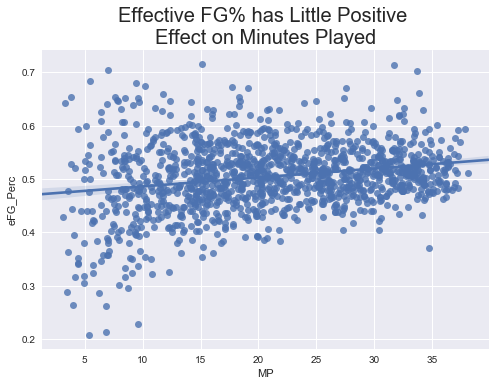

In [740]:
sns.set()
sns.regplot(df['MP'],df['eFG_Perc'])
plt.title('Effective FG% has Little Positive \nEffect on Minutes Played', fontsize=20)
plt.show()

The regression resulted in a very low p-value proving that there is a statistically significant relationship, however do to the low r-squared it has been determined that the correlation is quite weak.